In [11]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib


### Diagnóstico del modelo final (valid)

In [ ]:
# Cargamos validación y el modelo final guardado
OUT_DIR = "data/prep"

valid_df = pd.read_parquet(f"{OUT_DIR}/valid.parquet")
train_df = pd.read_parquet(f"{OUT_DIR}/train.parquet")
test_X   = pd.read_parquet(f"{OUT_DIR}/test_features.parquet")

with open(f"{OUT_DIR}/meta.json") as f:
    meta = json.load(f)

bundle = joblib.load("artifacts/model.joblib"")
clf = bundle["clf"]
reg = bundle["reg"]
feature_cols = bundle["feature_cols"]

X_valid = valid_df[feature_cols]
y_valid = valid_df["y"].astype(np.float32).values

p_valid = clf.predict_proba(X_valid)[:, 1].astype(np.float32)
mu_valid = reg.predict(X_valid).astype(np.float32)
pred_valid = np.clip(p_valid * mu_valid, 0, 20)

rmse = float(np.sqrt(np.mean((pred_valid - y_valid) ** 2)))
print("RMSE valid:", rmse)


RMSE valid: 0.7547085285186768


/tmp/ipython-input-2602281863.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = df.groupby("decile").agg(y_mean=("y","mean"), yhat_mean=("yhat","mean")).reset_index()


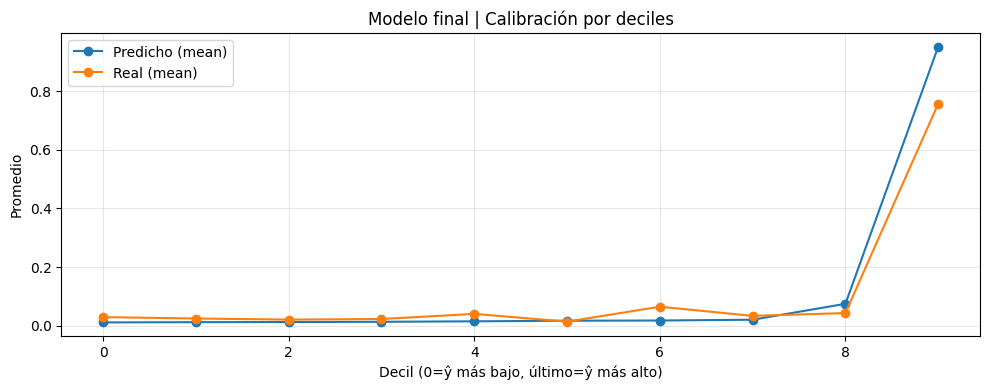

In [13]:
# Gráfica rápida: calibración por deciles (promedio real vs predicho)
def calibration_by_decile(y_true, y_pred, title):
    df = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    df["decile"] = pd.qcut(df["yhat"], 10, duplicates="drop")
    rep = df.groupby("decile").agg(y_mean=("y","mean"), yhat_mean=("yhat","mean")).reset_index()

    x = np.arange(len(rep))
    plt.figure(figsize=(10,4))
    plt.plot(x, rep["yhat_mean"], marker="o", label="Predicho (mean)")
    plt.plot(x, rep["y_mean"], marker="o", label="Real (mean)")
    plt.title(title)
    plt.xlabel("Decil (0=ŷ más bajo, último=ŷ más alto)")
    plt.ylabel("Promedio")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

calibration_by_decile(y_valid, pred_valid, "Modelo final | Calibración por deciles")


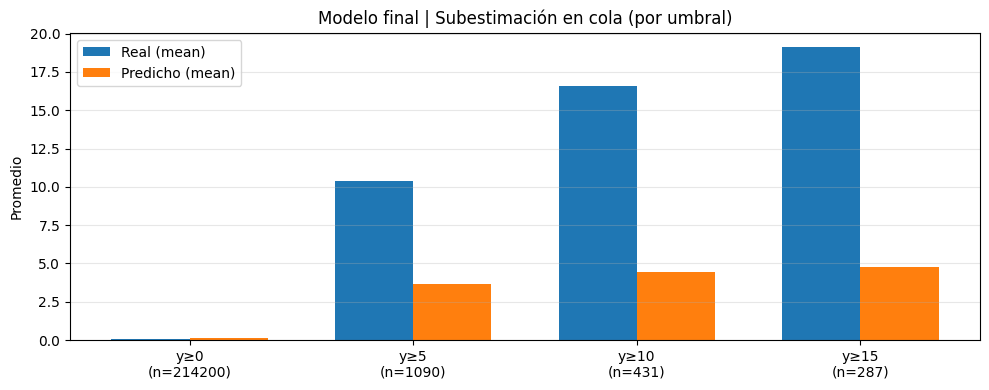

In [14]:
# En retail importa revisar la cola: los casos altos aunque sean pocos
def tail_bars(y_true, y_pred, title):
    df = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    thresholds = [0, 5, 10, 15]

    rows = []
    for thr in thresholds:
        sub = df[df["y"] >= thr]
        rows.append((thr, len(sub), sub["y"].mean(), sub["yhat"].mean()))
    rep = pd.DataFrame(rows, columns=["thr","n","mean_y","mean_yhat"])

    x = np.arange(len(rep))
    w = 0.35
    plt.figure(figsize=(10,4))
    plt.bar(x - w/2, rep["mean_y"], width=w, label="Real (mean)")
    plt.bar(x + w/2, rep["mean_yhat"], width=w, label="Predicho (mean)")
    plt.title(title)
    plt.xticks(x, [f"y≥{t}\n(n={n})" for t,n in zip(rep["thr"], rep["n"])])
    plt.ylabel("Promedio")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

tail_bars(y_valid, pred_valid, "Modelo final | Subestimación en cola (por umbral)")


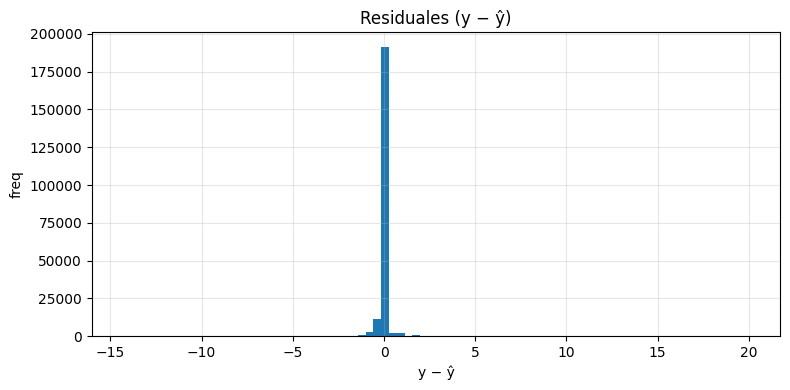

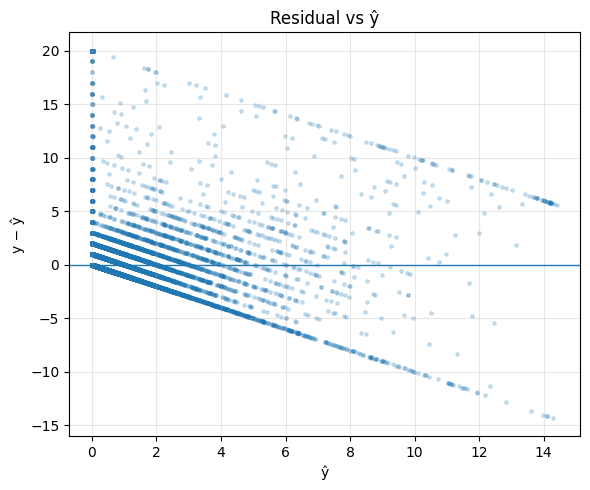

Bias (mean residual): -0.013199185021221638


In [15]:
# Residuales: ayuda a ver sesgo global y si hay "techo" en predicciones
res = y_valid - pred_valid

plt.figure(figsize=(8,4))
plt.hist(res, bins=80)
plt.title("Residuales (y − ŷ)")
plt.xlabel("y − ŷ")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(pred_valid, res, s=6, alpha=0.2)
plt.axhline(0, linewidth=1)
plt.title("Residual vs ŷ")
plt.xlabel("ŷ")
plt.ylabel("y − ŷ")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Bias (mean residual):", float(np.mean(res)))


### Baseline simple (solo regresión) y comparación con deciles

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5104
[LightGBM] [Info] Number of data points in the train set: 1713600, number of used features: 5
[LightGBM] [Info] Start training from score 0.104244
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.755031	valid_0's l2: 0.570072
RMSE valid baseline: 0.7550309300422668


/tmp/ipython-input-2602281863.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = df.groupby("decile").agg(y_mean=("y","mean"), yhat_mean=("yhat","mean")).reset_index()


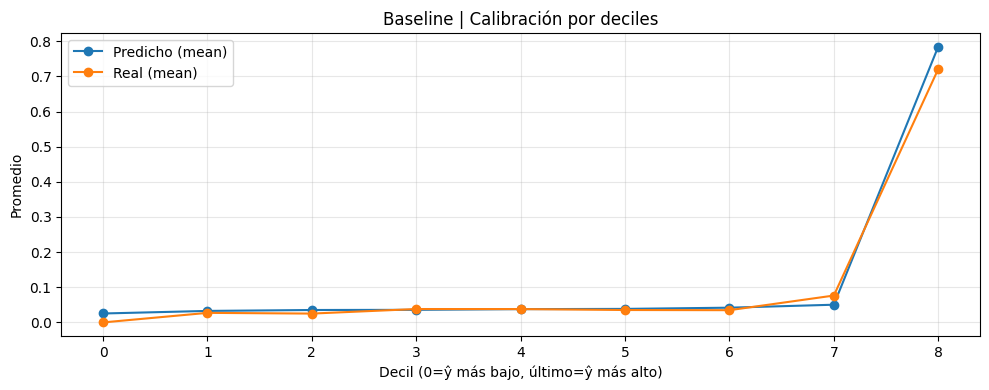

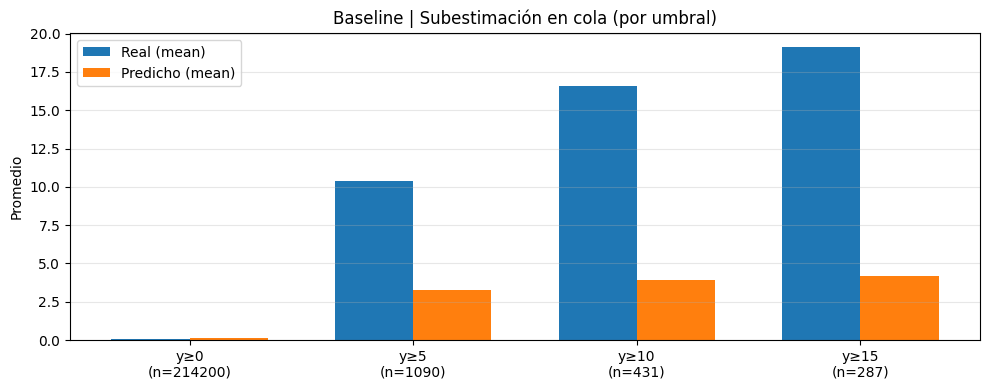

In [16]:
# Comparación con baseline simple (solo regresión con variables básicas)
basic_cols = []
for c in ["date_block_num", "month", "year", "shop_id", "item_id", "cnt_lag_1", "cnt_lag_12"]:
    if c in train_df.columns:
        basic_cols.append(c)

X_train_b = train_df[basic_cols]
y_train = train_df["y"].astype(np.float32)

X_valid_b = valid_df[basic_cols]

cat_features_b = [c for c in ["shop_id", "item_id", "month", "year"] if c in basic_cols]

baseline = lgb.LGBMRegressor(
    n_estimators=4000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)

baseline.fit(
    X_train_b, y_train,
    eval_set=[(X_valid_b, y_valid)],
    eval_metric="rmse",
    categorical_feature=cat_features_b,
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)]
)

pred_valid_base = np.clip(baseline.predict(X_valid_b).astype(np.float32), 0, 20)
rmse_base = float(np.sqrt(np.mean((pred_valid_base - y_valid) ** 2)))
print("RMSE valid baseline:", rmse_base)

calibration_by_decile(y_valid, pred_valid_base, "Baseline | Calibración por deciles")
tail_bars(y_valid, pred_valid_base, "Baseline | Subestimación en cola (por umbral)")


In [ ]:
joblib.dump(
    {"model": baseline, "basic_cols": basic_cols, "cat_features": cat_features_b},
    "artifacts/baseline.joblib"
)

In [17]:
# Simulación operativa simple: trade-off sobrestock vs stockouts
# La idea es medir qué pasa si usamos el forecast para fijar un stock objetivo del mes
y_true = y_valid
yhat_model = pred_valid
yhat_lag1 = np.clip(valid_df["cnt_lag_1"].astype(np.float32).values, 0, 20)

service_level = 0.95
z_map = {0.90: 1.2816, 0.95: 1.6449, 0.97: 1.8808, 0.99: 2.3263}
z = z_map.get(service_level, 1.6449)

holding_cost_per_unit = 1.0
stockout_cost_per_unit = 4.0

on_hand0 = yhat_lag1.copy()

def simulate_policy(y_true, y_forecast, on_hand0, z, sigma, h=1.0, p=4.0):
    target = np.clip(y_forecast + z * sigma, 0, 20)
    order_qty = np.maximum(0.0, target - on_hand0)

    available = on_hand0 + order_qty
    sales = np.minimum(available, y_true)

    end_inv = available - sales
    lost = y_true - sales

    holding_cost = h * end_inv
    stockout_cost = p * lost

    return {
        "end_inv": end_inv,
        "lost": lost,
        "holding_cost": holding_cost.sum(),
        "stockout_cost": stockout_cost.sum(),
        "total_cost": (holding_cost + stockout_cost).sum(),
        "fill_rate": sales.sum() / (y_true.sum() + 1e-9),
        "service_level": np.mean(lost == 0),
        "lost_units": lost.sum(),
    }

sigma_model = float(np.std(y_true - yhat_model))
sigma_lag1  = float(np.std(y_true - yhat_lag1))

sim_model = simulate_policy(y_true, yhat_model, on_hand0, z, sigma_model,
                            h=holding_cost_per_unit, p=stockout_cost_per_unit)
sim_lag1  = simulate_policy(y_true, yhat_lag1, on_hand0, z, sigma_lag1,
                            h=holding_cost_per_unit, p=stockout_cost_per_unit)

summary = pd.DataFrame([
    {
        "policy": "modelo_final",
        "fill_rate": sim_model["fill_rate"],
        "service_level": sim_model["service_level"],
        "lost_units": sim_model["lost_units"],
        "ending_inventory": sim_model["end_inv"].sum(),
        "total_cost": sim_model["total_cost"],
        "holding_cost": sim_model["holding_cost"],
        "stockout_cost": sim_model["stockout_cost"],
    },
    {
        "policy": "baseline_lag1",
        "fill_rate": sim_lag1["fill_rate"],
        "service_level": sim_lag1["service_level"],
        "lost_units": sim_lag1["lost_units"],
        "ending_inventory": sim_lag1["end_inv"].sum(),
        "total_cost": sim_lag1["total_cost"],
        "holding_cost": sim_lag1["holding_cost"],
        "stockout_cost": sim_lag1["stockout_cost"],
    }
])

display(summary)


,policy,fill_rate,service_level,lost_units,ending_inventory,total_cost,holding_cost,stockout_cost
0,modelo_final,0.717974,0.991457,6068.067383,278700.90625,302973.1875,278700.90625,24272.269531
1,baseline_lag1,0.724786,0.992339,5921.500000,313794.78125,337480.8125,313794.78125,23686.000000


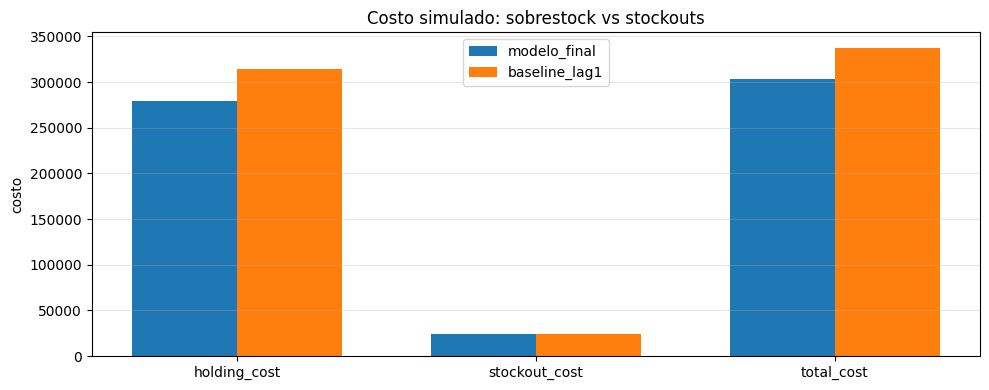

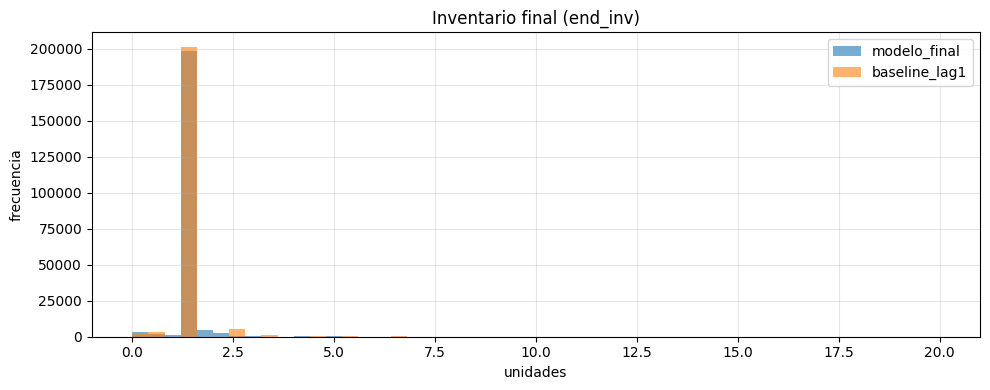

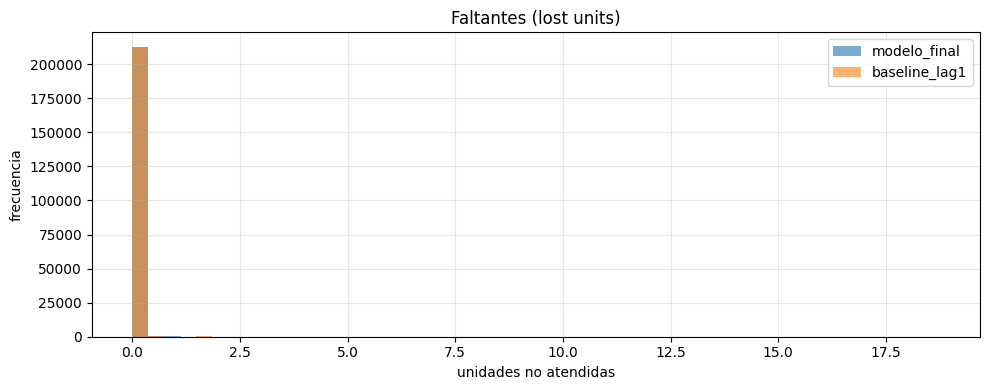

In [18]:
# Visualización rápida de costos e inventario/faltantes
labels = ["holding_cost", "stockout_cost", "total_cost"]
vals_model = [sim_model["holding_cost"], sim_model["stockout_cost"], sim_model["total_cost"]]
vals_lag1  = [sim_lag1["holding_cost"],  sim_lag1["stockout_cost"],  sim_lag1["total_cost"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - w/2, vals_model, width=w, label="modelo_final")
plt.bar(x + w/2, vals_lag1,  width=w, label="baseline_lag1")
plt.xticks(x, labels)
plt.title("Costo simulado: sobrestock vs stockouts")
plt.ylabel("costo")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(sim_model["end_inv"], bins=50, alpha=0.6, label="modelo_final")
plt.hist(sim_lag1["end_inv"], bins=50, alpha=0.6, label="baseline_lag1")
plt.title("Inventario final (end_inv)")
plt.xlabel("unidades")
plt.ylabel("frecuencia")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(sim_model["lost"], bins=50, alpha=0.6, label="modelo_final")
plt.hist(sim_lag1["lost"], bins=50, alpha=0.6, label="baseline_lag1")
plt.title("Faltantes (lost units)")
plt.xlabel("unidades no atendidas")
plt.ylabel("frecuencia")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Simulación operativa (inventario) + sensibilidad de costo de stockout

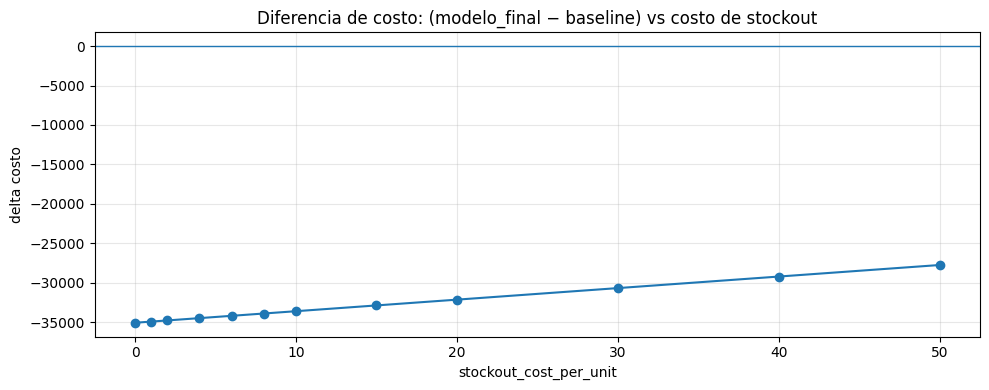

,stockout_cost_per_unit,delta_model_minus_lag1,total_cost_model,total_cost_lag1
0,0,-35093.87500,278700.90625,313794.78125
1,1,-34947.31250,284769.00000,319716.31250
2,2,-34800.81250,290837.03125,325637.84375
3,4,-34507.62500,302973.18750,337480.81250
4,6,-34214.46875,315109.34375,349323.81250
5,8,-33921.37500,327245.43750,361166.81250
6,10,-33628.21875,339381.59375,373009.81250
7,15,-32895.40625,369721.90625,402617.31250
8,20,-32162.46875,400062.28125,432224.75000
9,30,-30696.90625,460742.96875,491439.87500


In [19]:
# Sensibilidad: cuándo conviene el modelo vs baseline según el costo de un stockout
stockout_cost_grid = [0, 1, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

rows = []
for p_cost in stockout_cost_grid:
    sim_m = simulate_policy(y_true, yhat_model, on_hand0, z, sigma_model,
                            h=holding_cost_per_unit, p=p_cost)
    sim_b = simulate_policy(y_true, yhat_lag1, on_hand0, z, sigma_lag1,
                            h=holding_cost_per_unit, p=p_cost)
    rows.append({
        "stockout_cost_per_unit": p_cost,
        "delta_model_minus_lag1": sim_m["total_cost"] - sim_b["total_cost"],
        "total_cost_model": sim_m["total_cost"],
        "total_cost_lag1": sim_b["total_cost"],
    })

sens = pd.DataFrame(rows)

plt.figure(figsize=(10,4))
plt.plot(sens["stockout_cost_per_unit"], sens["delta_model_minus_lag1"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("Diferencia de costo: (modelo_final − baseline) vs costo de stockout")
plt.xlabel("stockout_cost_per_unit")
plt.ylabel("delta costo")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(sens)
